# 2022-02-07 • Big-N-to-1 simulation

In [1]:
# Pkg.resolve()

In [2]:
include("nb_init.jl")

[ Info: using Revise
[ Info: import Distributions
[ Info: import PyPlot
[ Info: import DataFrames, PrettyTables
[ Info: import MyToolbox
[ Info: Precompiling MyToolbox [54cd1024-cafd-4d62-948d-ced4874502bf]
[ Info: using VoltageToMap
[ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]


In [3]:
using Parameters, ComponentArrays
@alias CArray = ComponentArray;

In [4]:
save(fname) = savefig(fname, subdir="methods");

## Parameters

In [137]:
sim_duration = 0.11 * seconds
Δt = 0.1 * ms;  # size of first step only, when solver is adaptive

### Input spikers

In [138]:
N_unconn = 100
N_exc    = 5200
N_inh    = N_exc ÷ 4

1300

In [147]:
N_unconn = 1
N_exc    = 8
N_inh    = N_exc ÷ 4

2

In [148]:
N_conn = N_inh + N_exc

10

In [149]:
N = N_conn + N_unconn

11

In [10]:
input_spike_rate = LogNormal_with_mean(4Hz, √0.6)  # See the previous notebook

LogNormal{Float64}(μ=1.0862943611198905, σ=0.7745966692414834)

### Synapses

Reversal potential at excitatory and inhibitory synapses,  
as in the report [`2021-11-11__synaptic_conductance_ratio.pdf`](https://github.com/tfiers/phd-thesis/blob/main/reports/2021-11-11__synaptic_conductance_ratio.pdf):

In [11]:
v_exc =   0 * mV
v_inh = -65 * mV;

Exponential decay time constant of synaptic conductance `g`, $τ_{s}$ (`s` for "synaptic"):

In [91]:
τ_s =   7 * ms;

Synaptic conductances at `t = 0`:

In [13]:
g0 = 0 * nS;

### Izhikevich neuron

Membrane potential `v` and adaptation variable `u` at `t = 0`:

In [14]:
v0    = -80 * mV
u0    =   0 * pA;

Parameters for a cortical regular spiking neuron:

In [122]:
@with_kw struct IzhikevichParams
    C      = 100 * pF
    k      = 0.7 * (nS/mV)
    b      = -2 * nS
    v_r    = -60 * mV
    v_t    = -40 * mV
    v_peak =  35 * mV
    c      = -50 * mV       # reset voltage.
    a      = 0.03 / ms      # 1 / time constant of `u`
    d      = 100 * pA       # `u` increase on spike. Free parameter.
end

cortical_RS = IzhikevichParams();

## IDs

Simple here for the N-to-1 case: only input 'neurons' get an ID, and there is only one synapse for every (connected) neuron.

### Neuron IDs

In [99]:
neuron_ids = CArray(exc = 1:N_exc, inh = 1:N_inh, unconn = 1:N_unconn)

ComponentVector{Int64}(exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200], inh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300], unconn = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

In [100]:
only(getaxes(neuron_ids))

Axis(exc = 1:5200, inh = 5201:6500, unconn = 6501:6600)

In [107]:
resetrng!(797)
showsome(labels(neuron_ids))

6600-element Vector{String}:
    1: "exc[1]"
    2: "exc[2]"
    ⋮
 3012: "exc[3012]"
    ⋮
 5977: "inh[777]"
    ⋮
 6599: "unconn[99]"
 6600: "unconn[100]"


i.e. a neuron's **global** ID = its index into the [ComponentVector](https://github.com/jonniedie/ComponentArrays.jl) "`neuron_ids`".

### Synapse IDs

In [108]:
synapse_ids = CArray(exc = 1:N_exc, inh = 1:N_inh)

ComponentVector{Int64}(exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200], inh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300])

## Inputs

Generate firing rates $λ$ by sampling from the input spike rate distribution.

In [166]:
λ = rand(input_spike_rate, N)
showsome(λ)

11-element Vector{Float64}:
  1: 3.139294097672563
  2: 0.973035462513365
  ⋮
  5: 17.06493975019796
  ⋮
  9: 1.4261835387812887
 10: 1.8717092215968558
 11: 6.646960573121473


Alternative Exp parametrisation: scale $β$ = 1 / rate.

In [159]:
β = 1 ./ λ
ISI_distributions = Exponential.(β);
#   This uses julia's broadcasting `.` syntax: make an `Exponential` distribution for every value in the β vector

Create $E_i$: for each neuron, the reversal potential at its downstream synapses.

In [160]:
E = CArray(exc=fill(v_exc, N_exc), inh=fill(v_inh, N_inh))

ComponentVector{Float64}(exc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], inh = [-0.065, -0.065])

## Sim

In [170]:
neuron_ids

ComponentVector{Int64}(exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200], inh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300], unconn = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

In [171]:
using DataStructures: PriorityQueue

In [172]:
first_spiketimes = rand.(ISI_distributions)

pq = PriorityQueue{Int, Float64}()
for (neuron_ID, t) in enumerate(first_spiketimes)
    enqueue!(pq, neuron_ID => t)
end

next_spike_time, neuron_ID = dequeue_pair!(pq)

# t = 0s
# while t < sim_duration
#     input_neuron, t = dequeue_pair!(pq)  # earliest spike
#     new_ISI = rand(ISI_distributions[input_neuron])
#     enqueue!(pq, input_neuron => t + new_ISI)
# end

10 => 0.00936299467875174

In [153]:
using OrdinaryDiffEq

In [158]:
function f(D, vars, params, _t)
    @unpack v, u, g = vars
    @unpack C, k, b, v_r, v_t, v_peak, c, a, d = params
    I_s = sum(g .* (v .- E))
        # Membrane current is by convention positive if positive charges are flowing out of the cell.
        # For v = -80 mV and v_s = 0 mV, we get negative I_s, i.e. charges flowing in ✔.
    D.v = (k * (v - v_r) * (v - v_t) - u - I_s) / C
    D.u = a * (b * (v - v_r) - u)
    D.g = -g ./ τs
    return nothing
end

# distance_to_thr_crossing(vars, _t, integrator) = integrator.p.v_peak - vars.v
distance_to_thr_crossing(vars, _t, integrator) = v0 - vars.v
    # Function that is zero at desired event.

function on_thr_crossing(integrator)
    vars, params = integrator.u, integrator.p
    vars.v = v0
#     vars.v = params.c
#     vars.u += params.d
end

cb = ContinuousCallback(distance_to_thr_crossing, on_thr_crossing)

x0 = ComponentArray{Float64}(v = v0, u = u0, g = fill(g0, N_conn))  # Note eltype cast to float.
prob = ODEProblem(f, x0, float(sim_duration), cortical_RS)  # Time must also be float.
@time sol = solve(
    prob,
    Tsit5();          # The default solver. A Runge-Kutta method. Tsitouras 2011.
    dt = Δt,          # Size of first step.
    adaptive = true,  # Take larger steps when output is steady.
    reltol = 1e-8,    # default: 1e-2
    abstol = 1e-8,    # default: 1e-6
    callback = cb,
);

  3.335524 seconds (2.66 M allocations: 133.694 MiB, 2.86% gc time, 99.90% compilation time)


Tolerances from https://diffeq.sciml.ai/stable/tutorials/ode_example/#Choosing-a-Solver-Algorithm and experimentation:  
Lower for either gives incorrect oscillations in steady state (non-todo: show this in a separate nb).

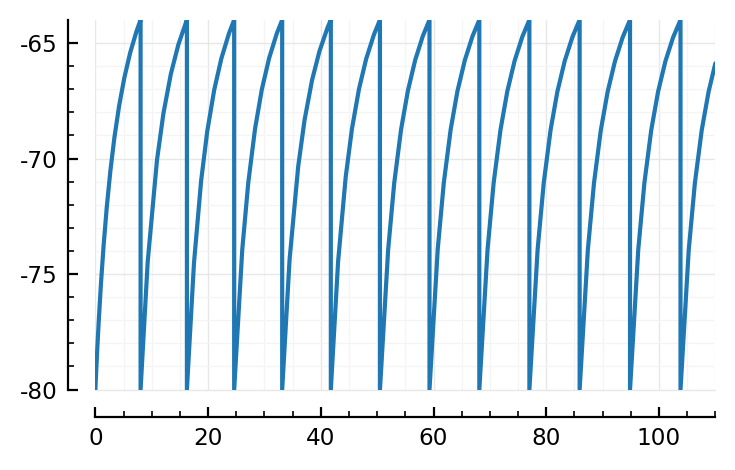

In [157]:
plot(sol.t/ms, sol[1,:]/mV);